## 프로젝트: SentencePiece 사용하기

- 라이브러리 확인
- SentencePiece 모델학습
- Tokenizer 함수 작성
- 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용

### 라이브러리 확인

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


In [2]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!mkdir -p ~/aiffel/sp_tokenizer/data
!mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
!cd ~/aiffel/sp_tokenizer/data
!tar -xzvf korean-english-park.train.tar.gz

--2023-08-16 07:43:38--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2023-08-16 07:43:38--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean

In [3]:
!pip install sentencepiece

In [4]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [5]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [6]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [7]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


In [8]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1


In [9]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [10]:
split_corpus = []
for kor in filtered_corpus:
    split_corpus.append(kor.split())


In [11]:
split_tensor, split_tokenizer = tokenize(split_corpus)
print("Split Vocab Size:", len(split_corpus))

Split Vocab Size: 76908


In [12]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


In [13]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [14]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


In [17]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Aug 16 07:44 korean_spm.model
-rw-r--r-- 1 root root 146213 Aug 16 07:44 korean_spm.vocab


In [18]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
#print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))


# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
아버지가방에들어가신다.


## 네이버 영화 감성 분석

### 데이터 로드

In [19]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fd530a9bdf0>)

In [21]:
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


결측치 확인 및 제거

중복값 확인 및 제거

In [22]:
# 중복 및 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


In [23]:
# 네이버 영화 리뷰 부분에 해당하는 document 컬럼 cleaned_corpus에 할당
data = list(train_data['document']) + list(test_data['document'])


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


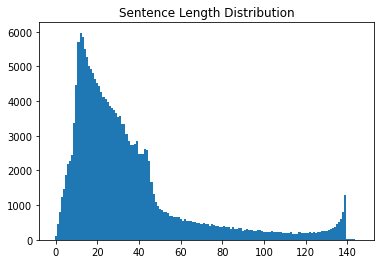

In [74]:
# 데이터에서 중복 제거하기
min_len= 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int32)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1



plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

90


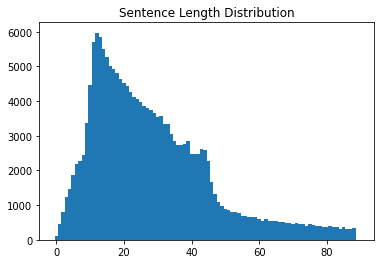

In [93]:
max_len = 90
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1


print(len(sentence_length))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [94]:
import sentencepiece as spm
import os
temp_file = "./rating_test.txt.temp"

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=sp_korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)


!ls -l sp_korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./rating_test.txt.temp --model_prefix=sp_korean_spm --vocab_size=10000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./rating_test.txt.temp
  input_format: 
  model_prefix: sp_korean_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  e

-rw-r--r-- 1 root root 414133 Aug 16 08:25 sp_korean_spm.model
-rw-r--r-- 1 root root 185416 Aug 16 08:25 sp_korean_spm.vocab


In [79]:

# sentencepiece 모델이 잘 적용됐는지 확인해보기
s = spm.SentencePieceProcessor() 
s.Load('sp_korean_spm.model') # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
#print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1632, 10, 424, 15, 1507, 10, 160, 17, 4]
아버지가방에들어가신다.


In [104]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./sp_korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}



    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [97]:
# 데이터 분할
X_train = tensor[:146182]
X_test = tensor[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 132)
(96182,)


In [99]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 200

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(128))   
model_rnn.add(keras.layers.Dense(32, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 2,172,609
Trainable params: 2,172,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5


es = EarlyStopping(monitor='val_loss', mode='min')


history = model.fit(partial_X_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size=128,
                      validation_data=(x_val, y_val),
                        callbacks=[es])

In [101]:
# 평가하기
results_rnn = model.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

1537/1537 - 5s - loss: 0.6932 - accuracy: 0.4973
[0.6931993961334229, 0.4972842037677765]


In [113]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

print(len(tensor))
print(len(filtered_corpus))
x_train, val_x, y_train, val_y = train_test_split(tensor, filtered_corpus, test_size=0.2)

print(len(x_train))
print(len(y_train))

y_train = np.array(y_train)
val_y = np.array(val_y)

179899
179899
143919
143919


In [114]:
from keras.callbacks import EarlyStopping
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5


es = EarlyStopping(monitor='val_loss', mode='min')

history = model.fit(x_train,
                    y_train,
                      epochs=epochs,
                      batch_size=128,
                      validation_data=(val_x, val_y),
                        callbacks=[es])


143919
143919
Epoch 1/5


UnimplementedError: 2 root error(s) found.
  (0) Unimplemented:  Cast string to float is not supported
	 [[node binary_crossentropy/Cast (defined at tmp/ipykernel_31/145684681.py:13) ]]
  (1) Cancelled:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_124601]

Function call stack:
train_function -> train_function
